In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [19]:
df_train_raw = pd.read_csv('data/train.csv')
df_train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [26]:
df_train_raw.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [27]:
len(df_train_raw.columns)

81

In [21]:
top_corr_predictors = np.abs(df_train_raw.corr()['SalePrice']).sort_values(ascending=False)[0:11].index.values

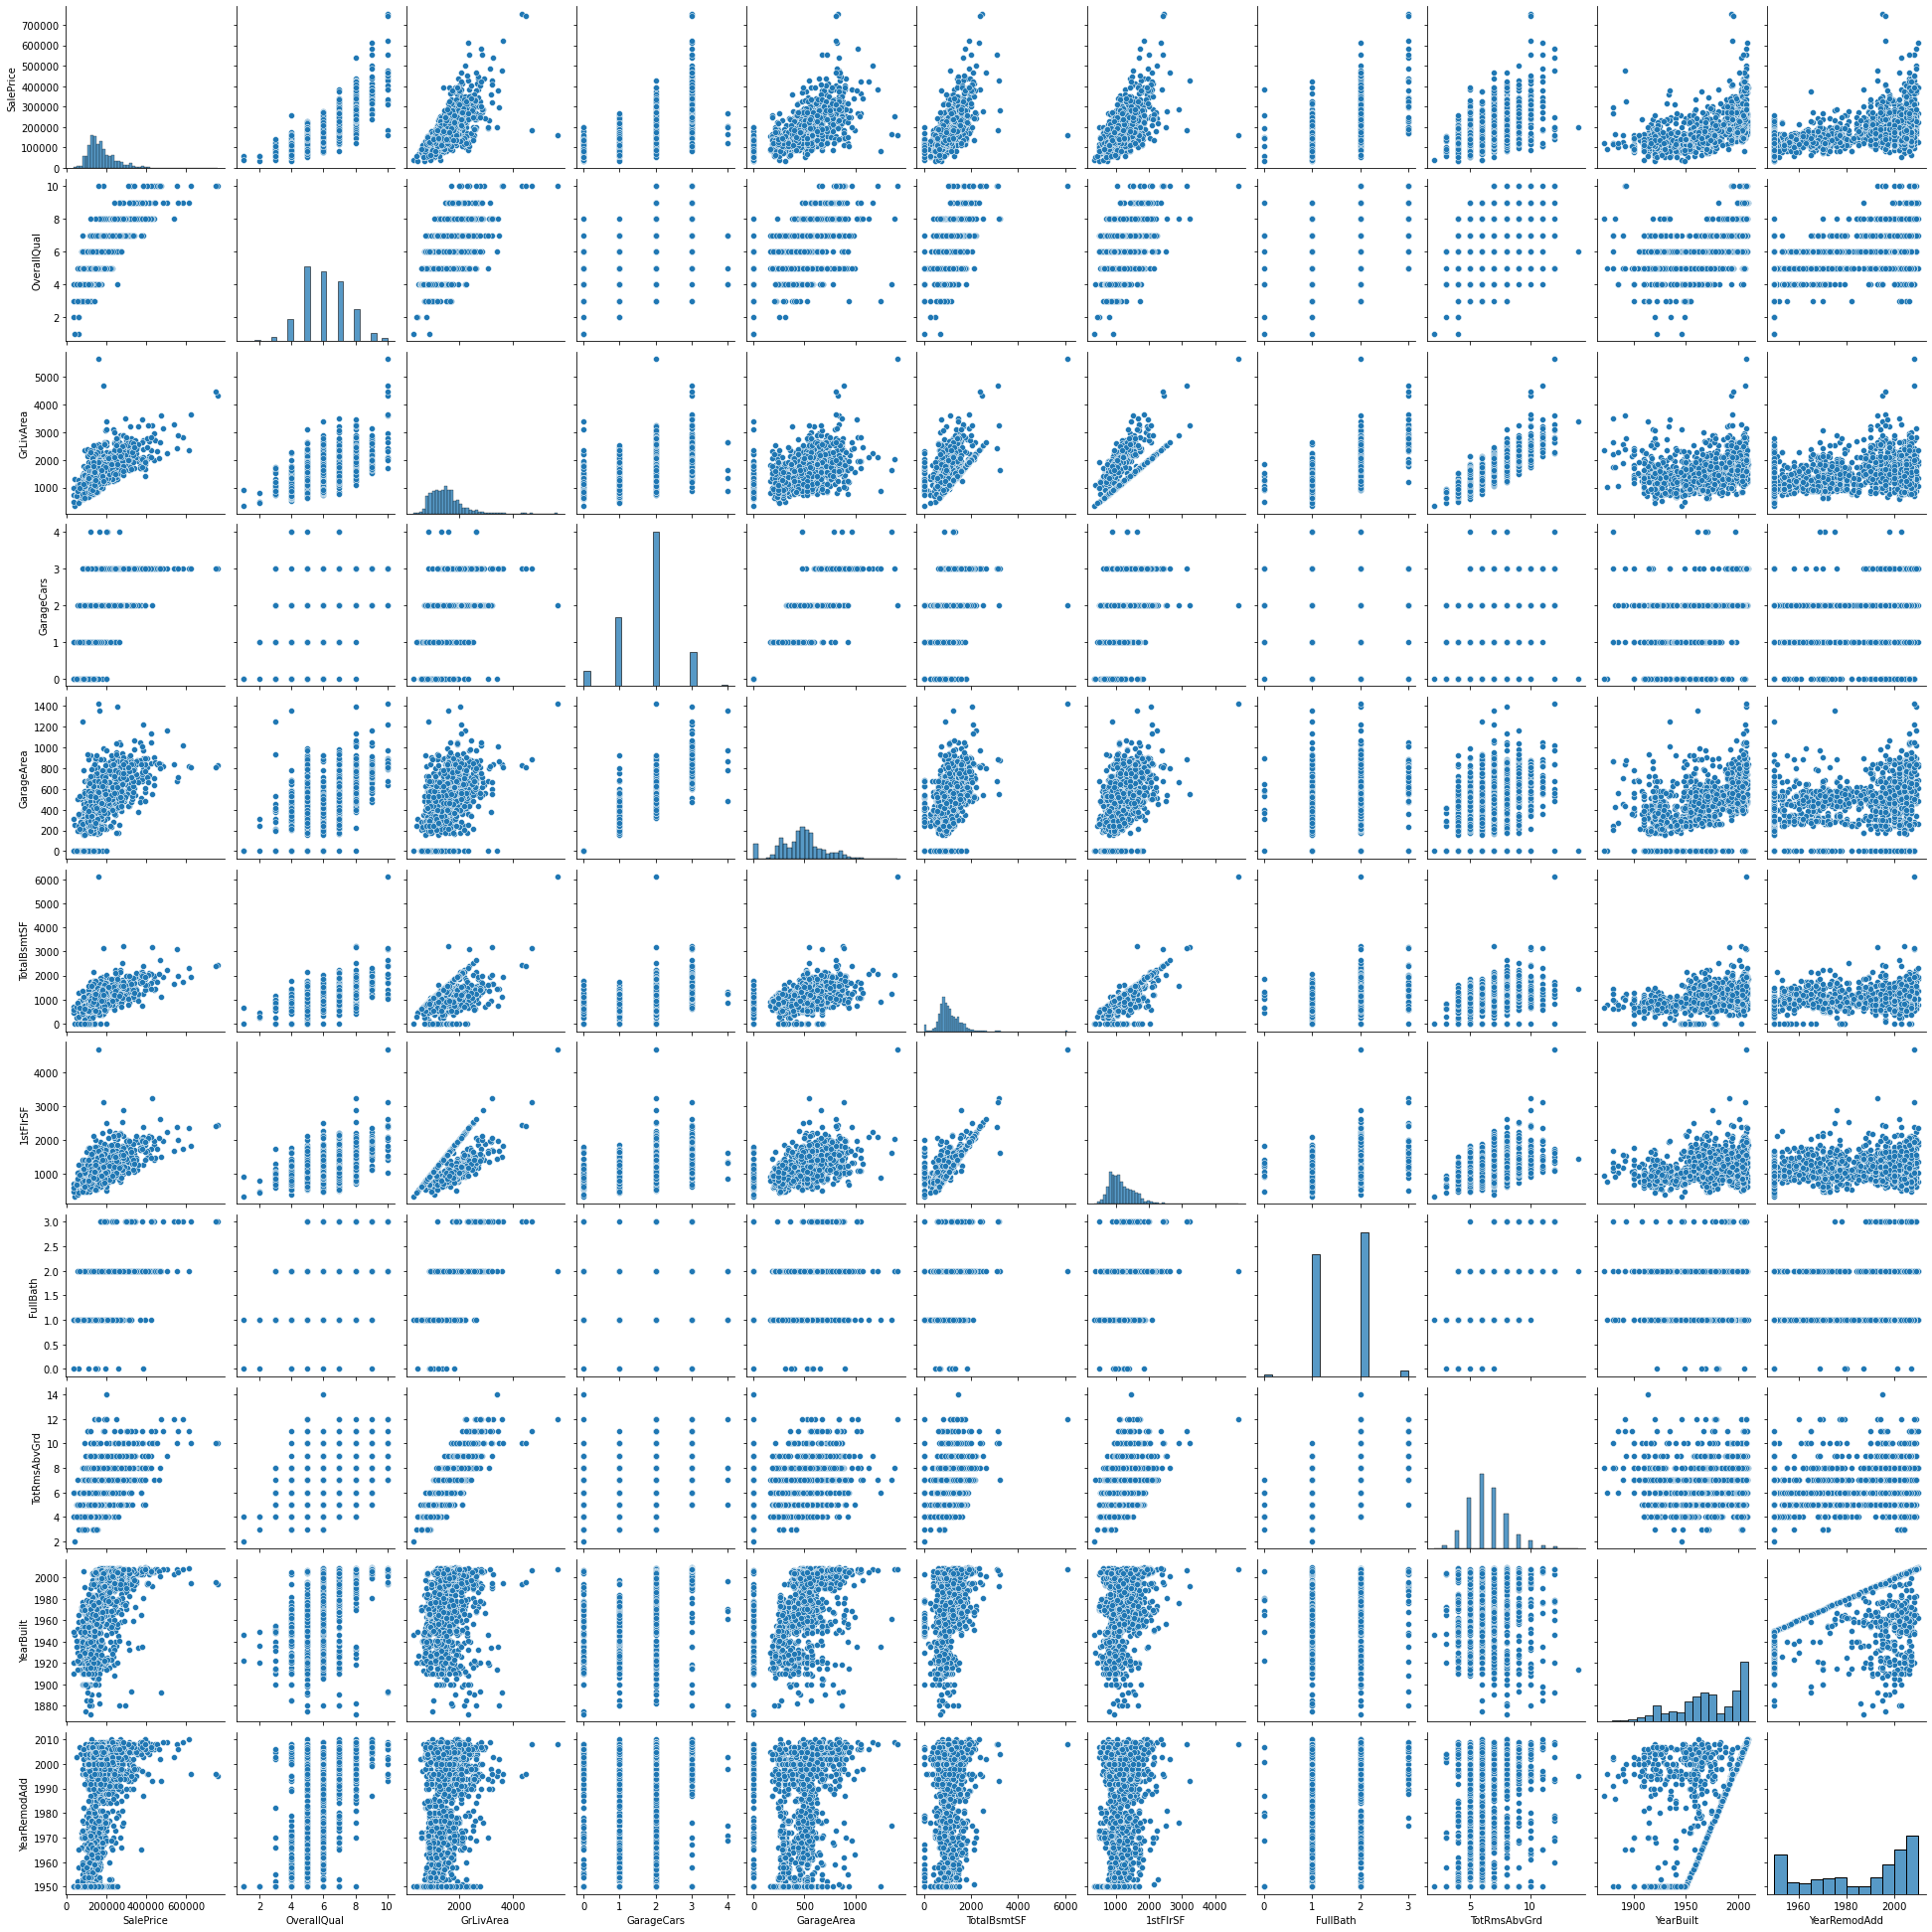

In [22]:
sns.pairplot(df_train_raw.loc[:, top_corr_predictors])

KeyError: 0

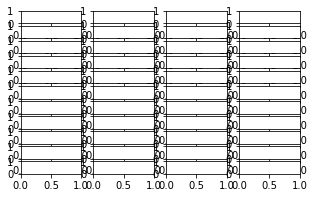

In [70]:
object_list = []

for k, v in df_train_raw.dtypes.items():
    if v == 'object':
        object_list.append(k)

# len(object_list)
fig, axs = plt.subplots(ncols=4, nrows=11, figsize=(5, 3), constrained_layout=True)

test_comb = []
for i in range(len(object_list)):
    row = i%11
    col = i//11
    axs[col][row].plot(df_train_raw.groupby(i).SalePrice)



# Data Cleaning / Feature Engineering

## Missing Data

<AxesSubplot:>

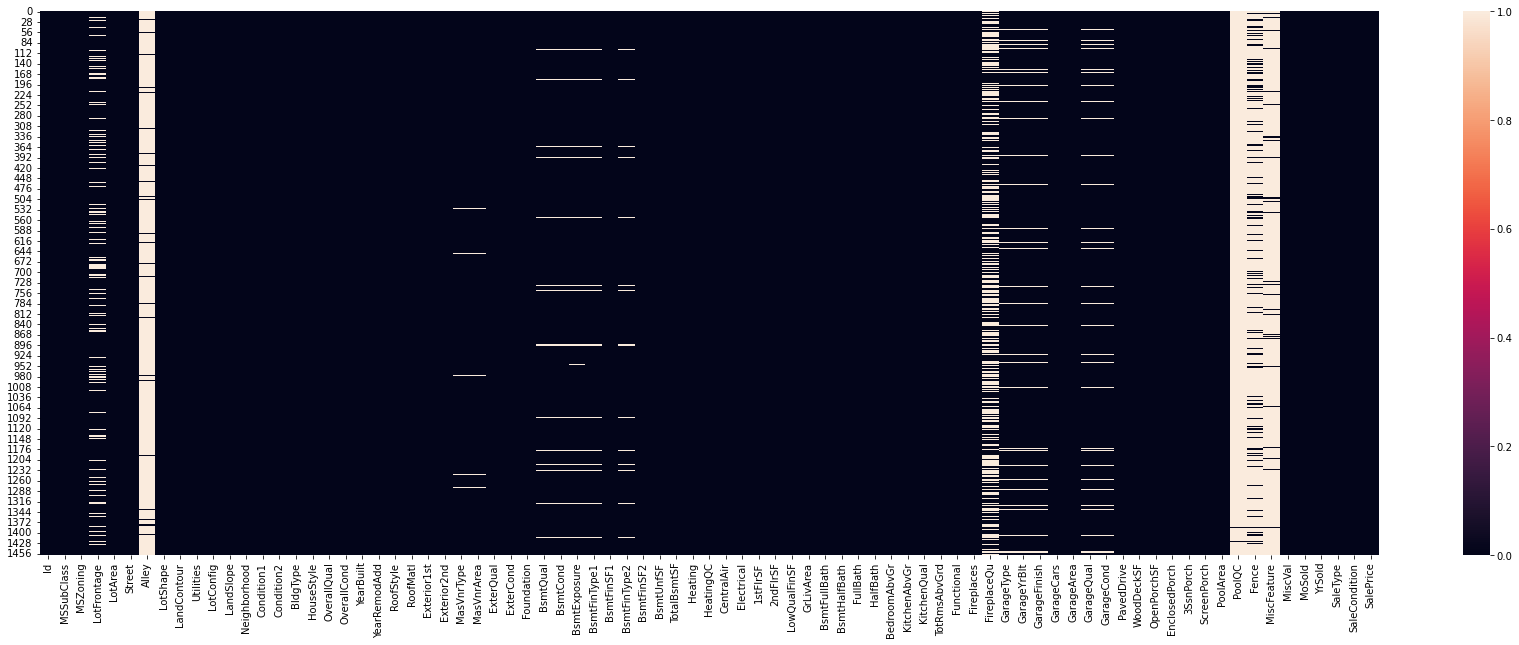

In [40]:
plt.figure(figsize=(30, 10))

sns.heatmap(df_train_raw.isna())

### Dropping Variables w/ No Data

There are 5 variables that have very few data points available:
- `Alley`
- `FireplaceQu`
- `PoolQC`
- `Fence`
- `MiscFeature`

It would be very difficult to impute this data, so I dropped them

In [41]:
df_train_transition = df_train_raw.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

### Lot Area Imputation

Lot area can be based on the `LotConfig` and `LotShape`

In [36]:
df_train_raw.groupby(['LotShape', 'LotConfig']).LotArea.agg(['count', 'mean'])

count          mean
LotShape LotConfig                     
IR1      Corner       107  13116.672897
         CulDSac       77  13407.532468
         FR2           15  12592.866667
         FR3            1   6155.000000
         Inside       284  11007.211268
IR2      Corner         8  17080.000000
         CulDSac       14  38389.285714
         FR2            5  15992.800000
         Inside        14  15644.714286
IR3      Corner         2  39229.500000
         CulDSac        2  23969.500000
         Inside         6  47830.666667
Reg      Corner       146   9496.684932
         CulDSac        1  12384.000000
         FR2           27   8143.037037
         FR3            3   9556.666667
         Inside       748   8775.020053

## Outliers

- Remove outliers in target variable: `SalePrice`
- Remove outliers in predictor variables:
    - `GrLivArea`
    - `GarageArea`
    - `TotalBsmtSF`